# PROJECT OVERVIEW

A predictive model will be developed to assess post-pandemic migratory patterns in the US. The US Census bureau published domestic migration totals by county from April 2020 - July 2021. We will use this as our target variable. Additional data about the counties will be collected and used for our model to help determine what factors are influencing migration within the US.

## Table of Contents
- **Target Variable Engineering:** *Derive census migration from census data set.*
- **Pipeline Construction:** *Consolidating census and IBRC data sources.*
- **Exploratory Data Analysis:** *Analyze relationships between features and target variable.*
- **Feature Engineering:** *Prepare pipeline for modeling.*
- **Modeling:** *Develop model iterations, tune preferred model, and optimize on target metrics.*

## Required Libraries

In [95]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score
from sklearn.tree import plot_tree

import shap

# TARGET VARIABLE ENGINEERING

## Data Preparation - Target Variable

The US census bureau publishes population estimates and categories of population change (births, deaths, domestic migration, international migration). Population change from 4/1/20 through 7/1/2021 (estimated) is used as it is the 15 months immediately following the pandemic. The target variable will use domestic migration and will be converted to percent migration for modeling to levelize for differences in county size.

Data Set and Data Dictionary Location:
https://www.census.gov/data/tables/time-series/demo/popest/2020s-counties-total.html

In [96]:
# Load census data for target variable construction.

TYPES = {'SUMLEV': object,
         'REGION': object,
         'DIVISION': object,
         'STATE': object,
         'COUNTY': object,
         'STNAME': object,
         'CTYNAME': object}
POP_FILE = 'co-est2021-alldata.csv'

population_df = pd.read_csv(POP_FILE, encoding='latin1', dtype=TYPES)

In [97]:
# Consolidate 2020 and 2021 domestic migration fields.

population_df['Total_Dom_Migration'] = population_df['DOMESTICMIG2020'] + population_df['DOMESTICMIG2021']

# Calculate percentage migration using total migration and population on 4/1/2020.

population_df['Perc_Dom_Migration'] = population_df['Total_Dom_Migration'] / population_df['ESTIMATESBASE2020']

In [98]:
# Domestic migration should net to zero as moves are from one county to another. Validate sum of migration.

population_df['Total_Dom_Migration'].sum()

0

## Target Variable

Migration appears to be normally distributed with the 25th percentile being -0.4% adn 75th percentile being 1.3%. 

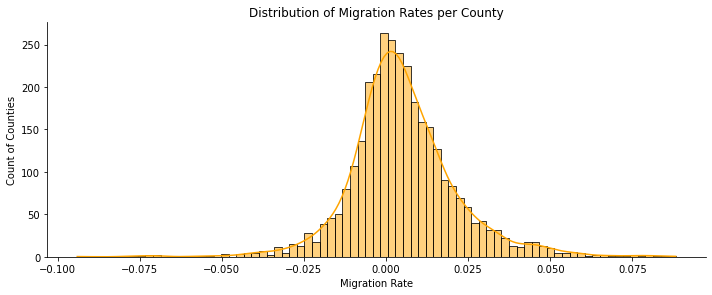

In [99]:
# Graph distribution of population migration percentages.

sns.displot(data=population_df, x='Perc_Dom_Migration', kde=True, height=4, aspect=2.5, color='orange')
plt.title('Distribution of Migration Rates per County')
plt.ylabel('Count of Counties')
plt.xlabel('Migration Rate')
plt.show()

In [100]:
# Descriptive statistics of target variable.

population_df['Perc_Dom_Migration'].describe()

count    3194.000000
mean        0.005101
std         0.016398
min        -0.094000
25%        -0.004013
50%         0.003615
75%         0.013044
max         0.088167
Name: Perc_Dom_Migration, dtype: float64

# PIPELINE CONSTRUCTION

#### Modifications to Population_df (Target Variable File

- Remove state level records (denoted as county number 000) since our model will be built at county level.
- Remove all columns reflecting data after 4/1/2020. The model predicts migrations from 4/1/20 - 7/1/21. All features should should reflect data prior to 4/1/20.
- Keep target variables and base population. Size of county may be a useful feature to indicate whether individuals are migrating to or from rural areas.

In [101]:
# Select retained fields for pipeline.

FIELDS = ['STATE', 'COUNTY', 'STNAME', 'CTYNAME',
          'ESTIMATESBASE2020', 'Total_Dom_Migration', 'Perc_Dom_Migration']

# Filter data set on features. As noted above, remove state-level records.

pipeline_df = population_df.loc[population_df['COUNTY']!='000', FIELDS]

#### Data File for Attributes

Data from statsamerica.org is used for model attributes. The Indiana Business Research Center (IBRC) at Indiana University publishes health, economic, and quality of life statistics for each county. The list was published in 2019 to help policymakers and other officials assess the performance of their county. This data contains numerous variables that would likely factor into a decision about citizens moving from one county to another.

Data Set and Dictionary (see Metrics for Development link): https://www.statsamerica.org/downloads/default.aspx#research

In [102]:
# Load data file 

VAR_FILE = 'Metrics for Development.csv'

feat_df = pd.read_csv(VAR_FILE, dtype={'Statefips':object, 'Countyfips':object})

In [103]:
# Unstack Code Description field using MD_Data as Variable

features = feat_df.pivot_table(index=['Statefips', 'Countyfips', 'Description'], 
                               columns='Code Description', 
                               values='M4D_Data')\
                  .reset_index()

#### Join Features to Pipeline
Consolidate target variable with Indiana County data set.

In [104]:
# Append features to pipeline.

pipeline_df = pipeline_df.merge(features, 
                              how='left', 
                              left_on=['STATE', 'COUNTY'],
                              right_on=['Statefips', 'Countyfips'],
                              validate='one_to_one')

In [105]:
# Verify pipeline shape.

print(f'Pipeline shape: {pipeline_df.shape}')

Pipeline shape: (3143, 237)


In [106]:
# Some counties are missing data for IBRC. Remove these counties.

pipeline_df = pipeline_df.loc[~pipeline_df.isnull().any(axis=1)]

In [107]:
# Verify shape of pipeline. Should be ~62 rows dropped and 3081 rows remaining.

pipeline_df.shape

(3081, 237)

In [108]:
# Pipeline detail. All features in our data are integers and floats, which we'll use for modeling.

pipeline_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3081 entries, 0 to 3142
Columns: 237 entries, STATE to emp., 2007-11 average
dtypes: float64(228), int64(2), object(7)
memory usage: 5.6+ MB


In [109]:
# Save pipeline to csv.
# pipeline_df.to_csv('pipeline_df.csv', index=False)

# FEATURE ENGINEERING

**Part 1:** 
Remove any columns that are not useful for modeling. These include:
1. Columns that are labels, such as state, county, and city names and codes.
2. Remove columns that have data after our projection or that are not useful features.
3. Remove all columns that are labeled with "index" in name. These are aggregations of other columns and would be duplicative features.

**Part 2:**
The data contains correlated fields that need to be manually reviewed and removed. Some of the correlated items occur because the data provider derived variables from other variables in the data set. The original variables were not removed. In other situations, related attributes are showing as highly correlated and need to be removed.

We will attempt to review and clean as many of the features by hand. Due to the size, not all features will be reviewed manually and will be addressed during modeling using PCA.

**Part 3:**
Convert base population to a log value. Population has a few cities with very large populations, and the log of the population totals are better correlated to migration percentages than the natural values.

# Load pipeline

PIPEFILE = 'pipeline_df.csv'
TYPES = {'STATE': object,
         'COUNTY': object,
         'Statefips': object,
         'Countyfips': object}

pipeline_df = pd.read_csv(PIPEFILE, dtype=TYPES)

In [110]:
# Verify load.

pipeline_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3081 entries, 0 to 3142
Columns: 237 entries, STATE to emp., 2007-11 average
dtypes: float64(228), int64(2), object(7)
memory usage: 5.6+ MB


#### Part 1: Removing any columns that are not relevant to modeling

In [111]:
# Remove column labels - city, state, and county names and codes.

DROPCOLS = ['STATE', 'COUNTY', 'STNAME', 'CTYNAME', 'Statefips', 'Countyfips']

try:
    pipeline_df.drop(DROPCOLS, axis=1, inplace=True)
except:
    print('Columns not removed properly.')

In [112]:
# Remove repetitive and irrelevant features.

DROPCOLS2 = ['Total_Dom_Migration', '2010 population', '2016 population estimate',
             'Indexed poor mental health days per month', 'Indexed poor physical health days per month',
             'Indexed share of emp. in top 2 local industries', 'Indexed share of emp. in top 3 industries',
             'Indexed share of emp. in top 5 traded industries', 'Indexed standardized score of topographical features',
             'Itemized contributions as share of total adjusted gross income', 'Number of tax returns, 2015',
             'Number of persons who moved in/out of county in last year from/to any US county/territory',
             'Percent of civilian population aged 18-64 that is uninsured',
             'Percent of civilian population aged 25-34 that is uninsured',
             'Percent of population that is low income and has low access to grocery stores',
             'Percent of the civilian population that is insured', 'Percent of the civilian population that is uninsured',
             'Population growth, 2010-2016', 'Population density', 'Population Dynamics', 
             'Share of emp. in top 2 local industries', 'Share of emp. in top 3 industries', 
             'Share of emp. in top 5 traded industries', 'Net migration rate', 'Description']

try:
    pipeline_df.drop(DROPCOLS2, axis=1, inplace=True)
except:
    print('Columns not removed properly.')

In [113]:
# Step 3: Remove all preconstructed index columns. These columns are aggregations of other columns in dataset.

DROPCOLS3 = []

for c in pipeline_df.columns:
    if 'index' in c.lower() or 'indexed' in c.lower():
        DROPCOLS3.append(c)
        
try:
    pipeline_df.drop(DROPCOLS3, axis=1, inplace=True)
except:
    print('Columns not removed properly.')

In [114]:
# Verify number of dropped columns. There are 141 columns remaining, generated from 237 in our original df.

pipeline_df.shape

(3081, 141)

#### Part 2: Run correlations between variables. 
- Remove redundant variables.
- Or create new features that combine or aggregate groups of similar fields.

In [115]:
# Calculate correlations for features. Then unstack columns to give a list of pairs and correlations.

corr_values = pipeline_df.corr()
corr_df = corr_values.unstack().reset_index()

corr_df.rename({0: 'correlation_value'}, axis=1, inplace=True)

In [116]:
# Review correlated pairs that exceed 80%.

pd.set_option('display.max_rows', 800)
pd.set_option('display.max_colwidth', None)

corr_df.loc[(corr_df['correlation_value']>0.80) & (corr_df['level_0']!=corr_df['level_1'])]

,level_0,level_1,correlation_value
2,ESTIMATESBASE2020,Adjusted gross income reported on itemized returns,0.894160
7,ESTIMATESBASE2020,Civilian population aged 25 and up,0.997983
23,ESTIMATESBASE2020,Itemized contributions,0.848252
76,ESTIMATESBASE2020,Population over the age of 25 that completed 5th and 6th grade,0.874248
77,ESTIMATESBASE2020,Population over the age of 25 that completed 7th and 8th grade,0.947851
78,ESTIMATESBASE2020,Population over the age of 25 that completed no school,0.923485
79,ESTIMATESBASE2020,Population over the age of 25 that completed nursery to 4th grade,0.877891
80,ESTIMATESBASE2020,Population that has low access to grocery stores,0.819157
84,ESTIMATESBASE2020,"QCEW emp., 2001-2016 Average",0.955526
85,ESTIMATESBASE2020,"QCEW emp., 2016",0.961090


In [117]:
# Create features from data set. Features will be percentages and proportions of populations to avoid correlations
# with the size of each county

# Feature 1: Funding per student. Set to 0 if enrollment is 0.
pipeline_df['Funding_Per_Student'] = pipeline_df['School Funding'] / pipeline_df['Total fall 2015 public school enrollment']
pipeline_df.loc[pipeline_df['Funding_Per_Student'].isnull(), 'Funding_Per_Student'] = 0

# Early Deaths per Capita
pipeline_df['Early_Deaths_(Yrs)'] = pipeline_df['Years of potential life lost to premature death (age-adjusted)'] /\
                                    pipeline_df['Total civilian population, 2016']

In [118]:
# Remove columns that are highly correlated in the data set. Manually reviewed and retained selected fields to ensure best
# fit with our intended model and business question.

CORRELCOLS = ['Adjusted gross income reported on itemized returns', 'Itemized contributions',
              'QCEW emp., 2001-2016 Average  ', 'QCEW emp., 2016  ', 'Total civilian population aged 18-64',
              'Total civilian population aged 25-34', 'Total civilian population, 2016',
              'Worked in County of Residence  ', 'Average of sk_litp and sk_lit8p', 'Full-Time Work',
              'Intensity of volunteerism', 'Ratio of interest on school system debt to total elementary-secondary expenditures',
              'Interval measure of volunteer hours  ', 'Natural Amenities', 'Natural amenity rank, 1=7, 7= high',
              'Percent of returns with itemized deductions', 'Percent of returns with self-emp. health insurance deduction',
              'Percent of working-age population that works full-time (35+ hours/week) year-round',
              'Percent of working-age population working full-time, year-round', 
              'Share of emp. in the 3rd-largest traded industry  ', 'Crime',
              'Share of emp. in the 4th-largest traded industry  ',
              'School Funding', 'Total fall 2015 public school enrollment',
              'Reported instances of property crime', 'Reported instances of violent crime  ',
              'Share of emp. in the 5th-largest traded industry  ',
              'Total school revenue from federal sources, thousands of current dollars',
              'Total school revenue from local sources, thousands of current dollars',
              'Total school revenue from state sources, thousands of current dollars',
              'emp. in arts occupations, 2007-11 average', 'emp. in creative class occupations, 2007-11 average',
              'emp. in social assistance industries (NAICS 624)', 'emp., 2007-11 average',
              'Rate Working Outside County of Residence  ', 'Total workers 16+ commuting to work, 2016',
              'Total school revenue, thousands of current dollars', 'Interest on debt per pupil', 'Commuting to Work',
              'Charitable Giving and Civil Society', 'Creative Class Occupations and Creative Industries',
              'Food Access', 'Civilian population aged 25 and up', 'Health', 'Industry Mix',
              'Jobs, Earnings, and Productivity', 'Literacy and Education',
              'Non-rent seeking organizations per 10,000 population'
              ]

try:
    pipeline_df.drop(CORRELCOLS, axis=1, inplace=True)
except:
    print('Columns not removed properly.')

In [119]:
# Final Review of Feature Columns

pd.set_option('display.max_columns', 100)

for c in pipeline_df.columns:
    print(c)

ESTIMATESBASE2020
Perc_Dom_Migration
Average earnings per worker growth, 2001-2016
Capital outlays per pupil
Farmers' markets per capita
Flag = 1 if state has expanded Medicaid
GDP per worker growth, 2001-2016
Grocery stores per capita
Interval measure of number of organizations at which one volunteers  
Long-term debt issued during FY per pupil
Long-term debt outstanding at the end of FY per pupil, thousands of current dollars
Low-income population with low access to grocery stores
Natural amenity scale
Payments sent to charter schools per pupil, thousands of current dollars
Payments sent to private schools per pupil, thousands of current dollars
Per capita income growth, 2001-2016
Percent of adults that are obese
Percent of adults that have diabetes
Percent of civilian population aged 18-64 that is insured
Percent of civilian population aged 25-34 that is insured
Percent of current spending for instruction
Percent of current spending spent on support services
Percent of population no

In [120]:
# Final Shape

pipeline_df.shape

(3081, 95)

In [121]:
# Verify no columns have null values.

pipeline_df.loc[pipeline_df.isnull().any(axis=1)]

,ESTIMATESBASE2020,Perc_Dom_Migration,"Average earnings per worker growth, 2001-2016",Capital outlays per pupil,Farmers' markets per capita,Flag = 1 if state has expanded Medicaid,"GDP per worker growth, 2001-2016",Grocery stores per capita,Interval measure of number of organizations at which one volunteers,Long-term debt issued during FY per pupil,"Long-term debt outstanding at the end of FY per pupil, thousands of current dollars",Low-income population with low access to grocery stores,Natural amenity scale,"Payments sent to charter schools per pupil, thousands of current dollars","Payments sent to private schools per pupil, thousands of current dollars","Per capita income growth, 2001-2016",Percent of adults that are obese,Percent of adults that have diabetes,Percent of civilian population aged 18-64 that is insured,Percent of civilian population aged 25-34 that is insured,Percent of current spending for instruction,Percent of current spending spent on support services,Percent of population not lacking basica prose skills,Percent of population that didn't work over the past year,Percent of population that has low access to grocery stores,Percent of population that works part-time (less than 35 hours a week),Percent of population with at least a bachelor's degree,Percent of population with high school diploma or equivalent,Percent of returns that are farm returns,Percent of returns with contributions,Percent of returns with partnership/S-Corp net income (less loss),Percent of returns with professional or business income,Percent of returns with salaries and wages,Percent of returns with self-emp. retirement plans,Percent of returns with self-emp. tax,Percent of returns with taxable Social Security benefits,Percent of revenue from federal sources,Percent of the population 25 and above that have completed more than 8th grade,Percent of total elementary-secondary expenditures for other elementary-secondary programs,Percent of total expenditures for current spending,Percent of total revenue from local sources,Percent of total revenue from state sources,Percent of working populaiton that drove to work alone,Percent of working population that carpooled to work,Percent of working population that took public transit (excluding taxicabs) to work,Percent of working population that walked to work,Percent of working-age population that works 48-52 weeks per year,Percent of working-age population working 1-13 weeks per year,Percent of working-age population working 14-39 weeks per year,Percent of working-age population working 40-47 weeks per year,Poor mental health days per month,Poor physical health days per month,Population over the age of 25 that completed 5th and 6th grade,Population over the age of 25 that completed 7th and 8th grade,Population over the age of 25 that completed no school,Population over the age of 25 that completed nursery to 4th grade,Population that has low access to grocery stores,Poverty rate,"Property crime events per 1,000 population",Proportion of single-parent households,Rate Working in County of Residence,Ratio of emp. in local industries to traded industries,Ratio of non-elementary-secondary expenditures to total elementary-secondary expenditures,Ratio of total capital outlays to elementary-secondary expenditures,"Rent-seeking organizations per 10,000 people",Residential stability,Rural-urban continuum code (1-9),SNAP benefits per capita,"Share of emp. in Arts occupations, 2007-11 avg","Share of emp. in Creative Class occupations, 2007-11 avg",Share of emp. in all local industries,Share of emp. in the 2nd-largest local industry,Share of emp. in the 2nd-largest traded industry,Share of emp. in the Arts & Entertainment occupation SC,Share of emp. in the Business & Other White Collar occupation SC,Share of emp. in the Business Services & Support industry supercluster (SC),Share of emp. in the College occupation SC,Share of emp. in the High IP Manufacturing industry SC,"Share of emp. in the Manufacturing, Tech

#### Part 3: Convert Population to Log Value

In [122]:
# Convert Base Population to a log value.

pipeline_df['Base_Population_2020'] = np.log(pipeline_df['ESTIMATESBASE2020'])

# Drop original column

pipeline_df.drop('ESTIMATESBASE2020', axis=1, inplace=True)

In [123]:
# Save file to disk
pipeline_df.to_csv('pipeline.csv', index=False)

# EXPLORATORY DATA ANALYSIS

#### Size of Existing County

External news reports suggest people are migrating from expensive larger cities to more affordable rural cities due to companies being more flexible with work arrangements. The size of county variable should pick up on this if true.

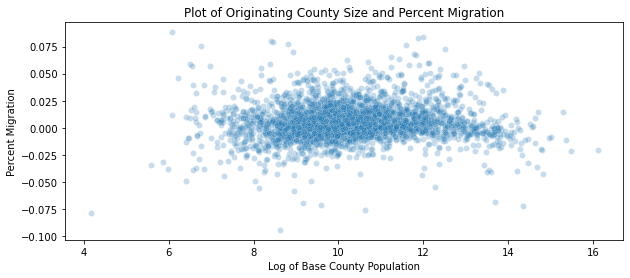

In [124]:
# Plot the log of population against target variable.

plt.figure(figsize=(10,4))
sns.scatterplot(data=pipeline_df, x='Base_Population_2020', y='Perc_Dom_Migration', alpha=0.25)
plt.title('Plot of Originating County Size and Percent Migration')
plt.xlabel('Log of Base County Population')
plt.ylabel('Percent Migration')
plt.show()

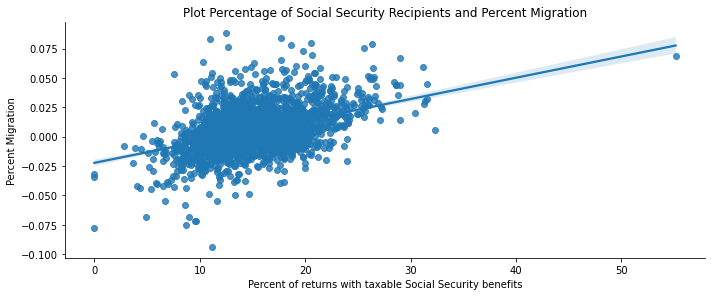

In [125]:
# Plot the social security returns against target variable.

sns.lmplot(data=pipeline_df, x='Percent of returns with taxable Social Security benefits', y='Perc_Dom_Migration',
           height=4, aspect=2.5)
plt.title('Plot Percentage of Social Security Recipients and Percent Migration')
plt.xlabel('Percent of returns with taxable Social Security benefits')
plt.ylabel('Percent Migration')
plt.show()

In [126]:
# Correlation Matrix: Calculate correlations for features. Review correlations to target variable.

corr_values = pipeline_df.corr()
corr_df = corr_values.unstack().reset_index()

corr_df.loc[corr_df['level_0']=='Perc_Dom_Migration'].sort_values(by=0, ascending=False)

,level_0,level_1,0
0,Perc_Dom_Migration,Perc_Dom_Migration,1.000000
34,Perc_Dom_Migration,Percent of returns with taxable Social Security benefits,0.406756
11,Perc_Dom_Migration,Natural amenity scale,0.257530
84,Perc_Dom_Migration,Standardized score of July mean temperature,0.195694
85,Perc_Dom_Migration,Standardized score of topographical features,0.192217
30,Perc_Dom_Migration,Percent of returns with professional or business income,0.185258
28,Perc_Dom_Migration,Percent of returns with contributions,0.184984
90,Perc_Dom_Migration,"emp. growth, 2001-2016",0.172333
21,Perc_Dom_Migration,Percent of population not lacking basica prose skills,0.147575
68,Perc_Dom_Migration,"Share of emp. in Creative Class occupations, 2007-11 avg",0.144396


In [127]:
# Exhibit for book

corr_df.loc[corr_df['level_0']=='Perc_Dom_Migration', ('level_1', 0)]\
    .sort_values(by=0, ascending=True)\
    .head(11)

,level_1,0
31,Percent of returns with salaries and wages,-0.339676
43,Percent of working population that took public transit (excluding taxicabs) to work,-0.210959
59,Rate Working in County of Residence,-0.208706
15,Percent of adults that are obese,-0.199382
58,Proportion of single-parent households,-0.176096
56,Poverty rate,-0.161928
14,"Per capita income growth, 2001-2016",-0.160022
91,"emp. in social assistance and outreach industries per 10,000 population",-0.155356
66,SNAP benefits per capita,-0.147618
5,"GDP per worker growth, 2001-2016",-0.146764


#### Select a Data Set Using the Top 10 Positive and Negative Correlated Values

In [128]:
# Use correlated list from above to select top correlated and uncorrelated values.

correlated_list = ['Perc_Dom_Migration',
                   'Percent of returns with taxable Social Security benefits',
                   'Natural amenity scale',
                   'Standardized score of July mean temperature',
                   'Standardized score of topographical features', 
                   'Percent of returns with professional or business income',
                   'Percent of returns with contributions', 
                   'emp. growth, 2001-2016', 
                   'Share of emp. in the largest local industry',
                   'Percent of population with at least a bachelor\'s degree',
                   'Percent of population not lacking basica prose skills',
                   'Percent of returns with salaries and wages',
                   'Percent of working population that took public transit (excluding taxicabs) to work',
                   'Rate Working in County of Residence  ',
                   'Percent of adults that are obese',
                   'Proportion of single-parent households',
                   'Poverty rate',
                   'emp. in social assistance and outreach industries per 10,000 population'
                   ]

pipeline_df_v2 = pipeline_df[correlated_list]

# MODEL BUILDING

A regression model will be developed. We will develop preliminary models using linear regression, ridge, and random forest regression algorithms. Analysis of the full data and PCA-transformed data suggests random forest is the better performing algorithm. We will tune this in the following section for our final outputs.

## Baseline Model - Single Linear Regression, using Social Security Variable

In [129]:
# Split dataframe into features and target variables.

base_feat = pipeline_df['Percent of returns with taxable Social Security benefits']
base_target = pipeline_df['Perc_Dom_Migration']

# Create train and test splits with 25% reserved for test set. For model building, we will use a fixed random set.

x_train_base, x_test_base, y_train_base, y_test_base = train_test_split(base_feat, base_target, test_size=0.25)
x_train_base = np.array(x_train_base).reshape(-1, 1)
x_test_base = np.array(x_test_base).reshape(-1, 1)

# Build Linear Regression Model

base_lm = LinearRegression()
base_model = base_lm.fit(x_train_base, y_train_base)

# Predict y-values and test.
y_pred_base = base_model.predict(x_test_base)
print(f'Test set R^2: {r2_score(y_test_base, y_pred_base)}')

Test set R^2: 0.21450174850347092


## Build a Linear Model w/ All Features
This model will be used to identify the features that are most useful. We will further segment the data once we select top features.

In [130]:
# Split dataframe into features and target variables.

features = pipeline_df.drop('Perc_Dom_Migration', axis=1)
target = pipeline_df['Perc_Dom_Migration']

# Create train and test splits with 25% reserved for test set. For model building, we will use a fixed random set.

x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.25)

In [131]:
# Develop a linear regression model using the pipeline. Apply standard scaler as a pre-processing step.

lm_pipe = Pipeline([('scaler', StandardScaler()), ('linreg', LinearRegression())])

# Fit linear model on our test set.

lm_pipe.fit(x_train, y_train)

# Create predictions on our test set.

y_pred = lm_pipe.predict(x_test)

# Score pipeline on training and test set.

print(f'Test set R^2: {r2_score(y_test, y_pred)}')

Test set R^2: 0.4687804466260359


In [132]:
# Create a list of coefficients

c1 = np.array(lm_pipe.feature_names_in_)
c2 = np.array(lm_pipe['linreg'].coef_)

feat_df = pd.DataFrame({'Feature_Name': c1, 'Coefficient': c2})

In [133]:
# Select features that have larger than a +/-10 coefficient.

top_features = feat_df.loc[(feat_df['Coefficient']>10) | (feat_df['Coefficient']<-10)]
top_features

,Feature_Name,Coefficient
18,Percent of current spending for instruction,382.481798
19,Percent of current spending spent on support services,292.058029
21,Percent of population that didn't work over the past year,1904.502889
36,Percent of total elementary-secondary expenditures for other elementary-secondary programs,80.308197
37,Percent of total expenditures for current spending,-579.560404
44,Percent of working-age population that works 48-52 weeks per year,1768.650045
45,Percent of working-age population working 1-13 weeks per year,339.414838
46,Percent of working-age population working 14-39 weeks per year,436.537633
47,Percent of working-age population working 40-47 weeks per year,270.206097


## Run Linear Regression Using PCA to Limit Features

Attempt to use a limited number of features to better capture model variance and remove any correlated variables in our dataset. Reductions in r-squared seem to be severe when removing features.

In [134]:
# Create a pipeline for our linear regression model, and run linear regression with PCA.

lm_pipe_pca = Pipeline(steps = [('scaler', StandardScaler()),
                                ('pca', PCA()),
                                ('classifier', LinearRegression())])
                  
search_space = {'pca__n_components': [5,10,15,20,25,35,50]}
                  
grid_lmpca = GridSearchCV(lm_pipe_pca, search_space, cv=5, verbose=0)
                  
best_model = grid_lmpca.fit(x_train, y_train)

y_pred_lmpca = best_model.predict(x_test)
                  
print(f'Test set R^2: {r2_score(y_test, y_pred_lmpca)}')
print(f'Number of features used: {grid_lmpca.best_estimator_.named_steps["pca"].n_components}')

Test set R^2: 0.4561915168821725
Number of features used: 50


## Run Ridge Regression to Reduce Coefficient Size
Ridge regression performs about the same as linear regression with PCA.

In [135]:
# Develop a Linear Regression model using the pipeline. Apply standard scaler as a pre-processing step.

pipe_r = Pipeline([('scaler', StandardScaler()), ('ridge', Ridge(alpha=0.1))])

# Fit linear model on our test set.

pipe_r.fit(x_train, y_train)

# Create predictions on our test set.

y_pred_r = pipe_r.predict(x_test)

In [136]:
# Score pipeline on training and test set.

print(f'Test set R^2: {r2_score(y_test, y_pred_r)}')
print(f'Number of features used: {pipe_r.n_features_in_}')

Test set R^2: 0.46807419723148
Number of features used: 94


## Create a Random Forest Regressor

In [137]:
# Tune random forest model using GridSearch CV. Use entire data set.

estimator = RandomForestRegressor()
param_grid = {"n_estimators"      : [20,30,40,50,60,70],
              "max_features"      : [10,15,20,25,30,35,40],
              "min_samples_split" : [2,4,8],
              "bootstrap"         : [True, False],
             }

# Find best parameters for random forest using grid search and cross-fold validation (5 times). 
# Optimize on root mean squared error

grid_rf = GridSearchCV(estimator, param_grid, cv=5, scoring="neg_mean_squared_error")
grid_rf.fit(x_train, y_train)

# Print best score and parameters

print(grid_rf.best_score_ , grid_rf.best_params_)

-0.00012295684782828313 {'bootstrap': False, 'max_features': 20, 'min_samples_split': 4, 'n_estimators': 70}


In [138]:
# Predict on test set and print scores.

y_pred_rf = grid_rf.predict(x_test)

print(f'Test set R^2: {r2_score(y_test, y_pred_rf)}')

Test set R^2: 0.5506311058025415


## Printing Final Model and Key Variables Used

In [139]:
# Pull the feature importance from our best model and save as Dataframe.

final_features = grid_rf.best_estimator_.feature_importances_
final_features_df = pd.DataFrame({'Feature_Name': features.columns,
                                 'Importance': final_features
                                 })

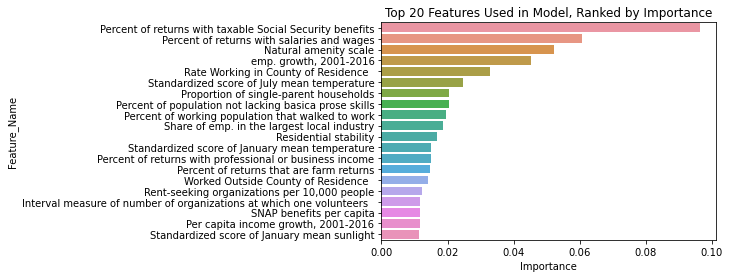

In [140]:
# Graph top 20 features as bar chart.

sns.barplot(data=final_features_df.sort_values(by='Importance', ascending=False).head(20),
            y='Feature_Name', x='Importance')
plt.title('Top 20 Features Used in Model, Ranked by Importance')
plt.show()

In [141]:
# Run SHAP values to identify the positive and negative values of features.

explainer = shap.TreeExplainer(grid_rf.best_estimator_)
shap_values = explainer.shap_values(x_train)

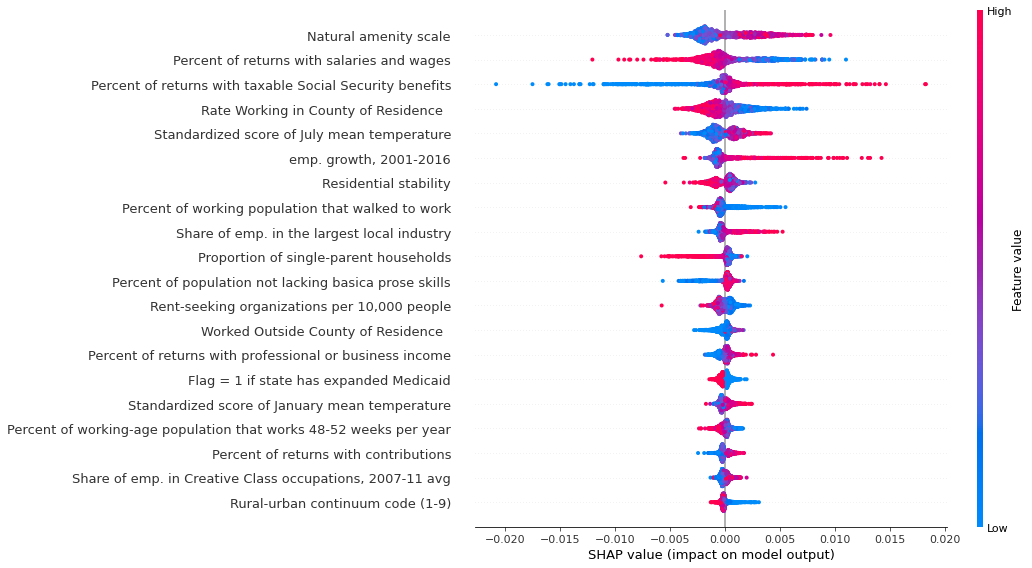

In [142]:
# Print the shapley values summary chart.

shap.summary_plot(shap_values, x_train, plot_size=(15,8))

### Run an Example for a Single County

In [163]:
x_test.shape, x_train.shape, pipeline_df.shape

((771, 94), (2310, 94), (3081, 95))

In [270]:
# Print Results of a Singular County
# Record index: 1702

population_df.loc[(population_df['Perc_Dom_Migration']>-0.004697) & (population_df['Perc_Dom_Migration']<-0.004695),
                  ('STATE', 'COUNTY', 'STNAME', 'CTYNAME', 'Perc_Dom_Migration')]

,STATE,COUNTY,STNAME,CTYNAME,Perc_Dom_Migration
1730,31,095,Nebraska,Jefferson County,-0.004696


In [273]:
# Print Pipeline Statistics
# Record index: 1702

record = pipeline_df.loc[pipeline_df.index==1702]
                   
record_df = pd.concat([record.mean(), pipeline_df.mean()], axis=1)\
                .rename(columns={0: 'Record: 1702', 1: 'Mean_Of_Counties'})

record_df

,Record: 1702,Mean_Of_Counties
Perc_Dom_Migration,-0.004696,0.005290
"Average earnings per worker growth, 2001-2016",0.039021,0.028214
Capital outlays per pupil,3.144174,1.300222
Farmers' markets per capita,0.135980,0.058253
Flag = 1 if state has expanded Medicaid,0.000000,0.509899
"GDP per worker growth, 2001-2016",0.031935,0.032492
Grocery stores per capita,0.266489,0.251464
Interval measure of number of organizations at which one volunteers,1.454373,1.490256
Long-term debt issued during FY per pupil,2.335089,1.142297
"Long-term debt outstanding at the end of FY per pupil, thousands of current dollars",4.658986,7.188539


In [286]:
# Print corresponding SHAP values
# Record index: 1702

shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0], features=x_train.iloc[0,:])